In [1]:
# import library 
import pickle
import tensorflow as tf
import numpy as np
import sys, os,cv2
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation
import seaborn as sns

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

In [6]:
# read the data shuffle 
data = pickle.load(open('../../DataSet/histopathology/histopathology.pkl', 'rb'),encoding='latin1')
train_data = np.asarray(data['training'])
test_data  = np.asarray(data['test'])

idx = np.random.permutation(len(train_data))
train_data = train_data[idx]
idx = np.random.permutation(len(test_data))
test_data = test_data[idx]

train_data=train_data.astype(np.float64);test_data=test_data.astype(np.float64)

print('Train Data Shape: ', train_data.shape)
print('Test  Data Shape: ', test_data.shape)

Train Data Shape:  (6800, 28, 28)
Test  Data Shape:  (2000, 28, 28)


In [11]:
train_data_x = train_data[:100,:,:,None]
print(train_data_x.shape)

(100, 28, 28, 1)


In [18]:

x = tf.placeholder(shape=(100,28,28,1),dtype=tf.float64)
patch = tf.image.extract_image_patches(
    images = x,
    ksizes = [1,4,4,1],
    strides= [1,5,5,1],
    rates  = [1,7,7,1],
    padding='VALID'
)

# sess = tf.InteractiveSession()
sess_results = sess.run(patch,feed_dict={x:train_data_x[:100]})
print(sess_results.shape)

(100, 2, 2, 16)


In [13]:
print(train_data_x.shape)
print(sess_results.shape)

(100, 28, 28, 1)
(100, 7, 7, 16)


In [ ]:
# view the train data set
fig=plt.figure(figsize=(20, 20))
columns = 12; rows = 12
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_data[i-1],cmap='gray')
    plt.axis('off')
    plt.title(str(i-1) + ' Image')
plt.show()

In [24]:
# Class for TF
class KPCA_layer():
    
    def __init__(self):
        pass
    def getw(self): return self.small_eigvec
    def feedforward(self,input,n_components,gamma = 15):
        self.input = input
        self.distance_matrix = -2 * tf.matmul(input,tf.transpose(input)) + tf.reduce_sum(input**2,axis=1) + tf.reduce_sum(input**2,axis=1)[:,tf.newaxis]
        self.k = tf.exp(-gamma * self.distance_matrix)
        N = self.k.shape[0].value
        ones = tf.ones([N,N],dtype=tf.float64) / N
        self.center_k = self.k - tf.matmul(ones,self.k) - tf.matmul(self.k,ones) + tf.matmul(tf.matmul(ones,self.k),ones)
        self.eigval,self.eigvec = tf.linalg.eigh(self.center_k)
        self.small_eigvec = self.eigvec[:,-n_components:]
        return self.small_eigvec
    
    def backprop_upsuper(self):
        pass
    
    def backprop(self,grad):
        pass

In [34]:
# create the layer and start the session and create graph
kpca_l = KPCA_layer()
# sess = tf.InteractiveSession()

x = tf.placeholder(shape=[28*28,1000],dtype=tf.float64)
n_components = tf.placeholder(shape=[],dtype=tf.int64)
gamma = tf.placeholder(shape=[],dtype=tf.float64)

kpca_data = kpca_l.feedforward(x,n_components=n_components,gamma=gamma)

(784, 100)


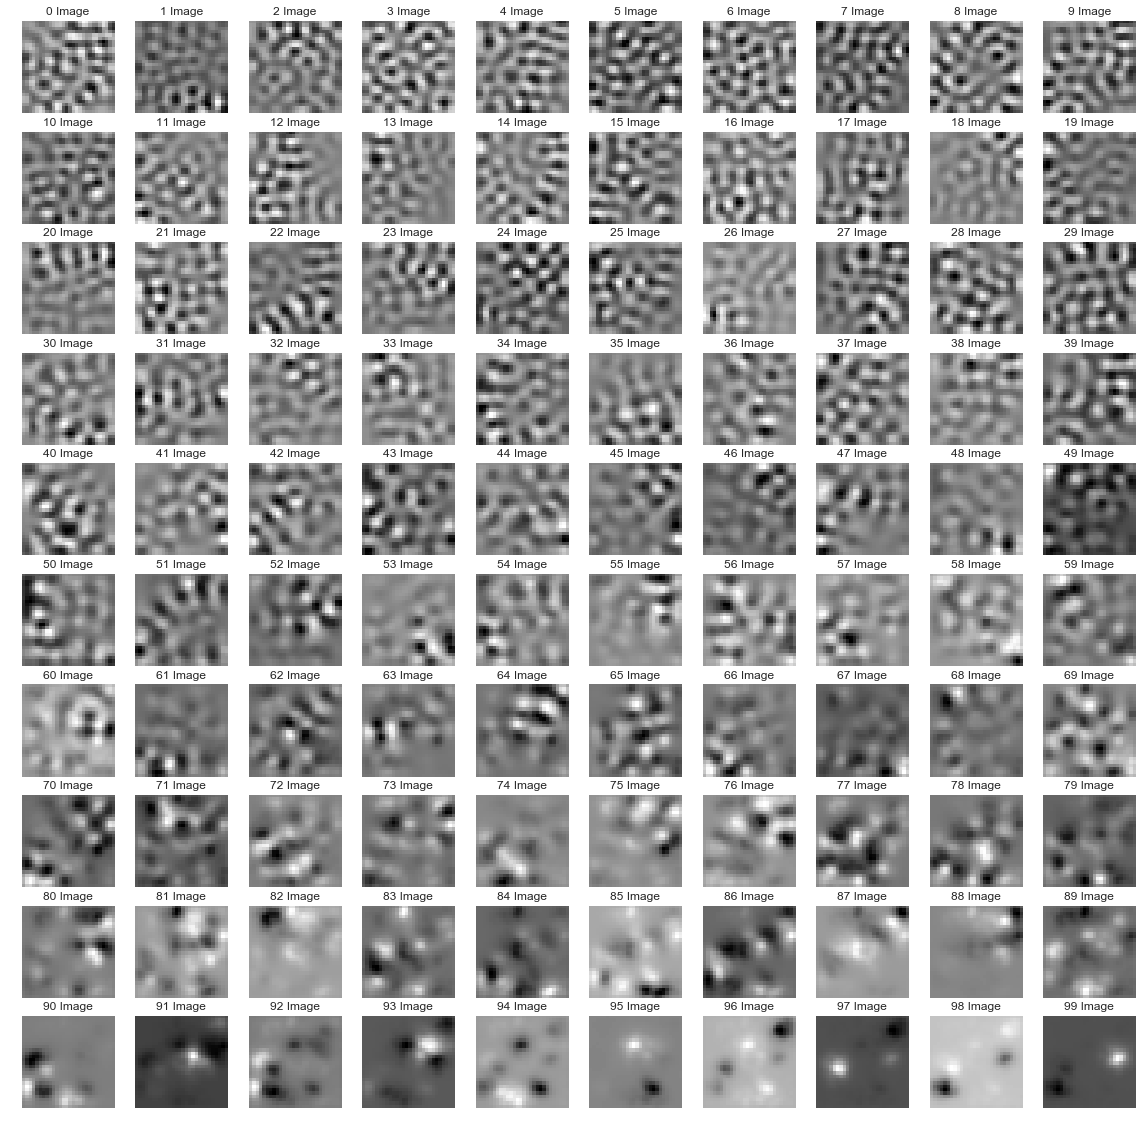

In [36]:
# tf KPCA and view the image
sess_results = sess.run([kpca_data,kpca_l.getw()],feed_dict={x:train_data[:1000,:].reshape([1000,-1]).T,n_components:100,gamma: 0.5 })
small_eig = sess_results[1]
sess_results = sess_results[0]
print(sess_results.shape)
fig=plt.figure(figsize=(20, 20))
columns = 10; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(sess_results[:,i-1].reshape((28,28)),cmap='gray')
    plt.axis('off')
    plt.title(str(i-1) + ' Image')
plt.show()

(784, 100)


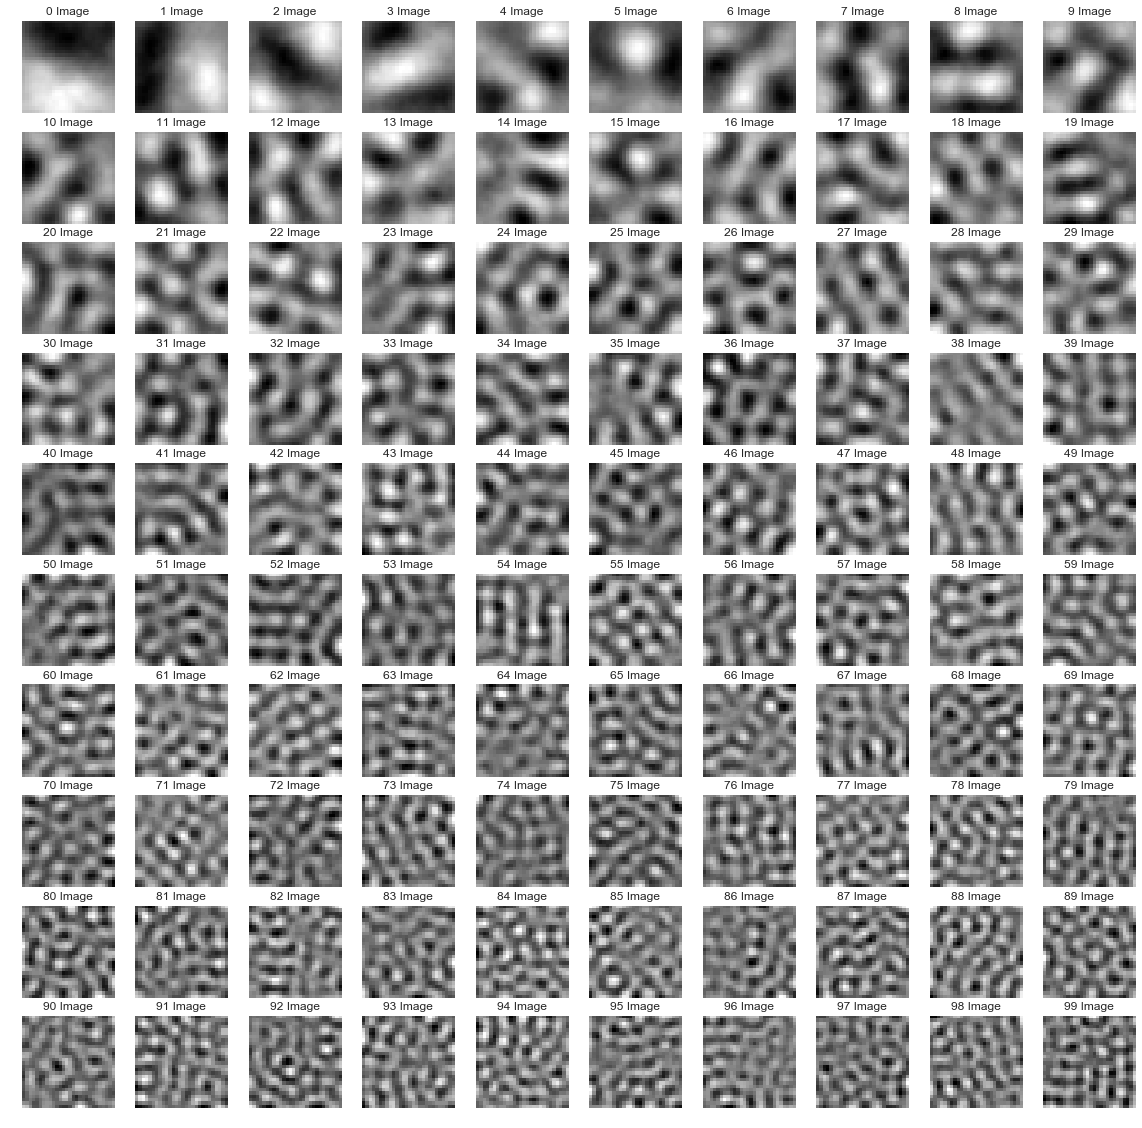

In [28]:
# do the reg pca and view the data
from sklearn.decomposition import PCA
reg_PCA = PCA(n_components=100)
reg_pca_data = reg_PCA.fit_transform(train_data[:1000,:].reshape(1000,-1).T)
print(reg_pca_data.shape)
fig=plt.figure(figsize=(20, 20))
columns = 10; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(reg_pca_data[:,i-1].reshape((28,28)),cmap='gray')
    plt.axis('off')
    plt.title(str(i-1) + ' Image')
plt.show()

(784, 100)


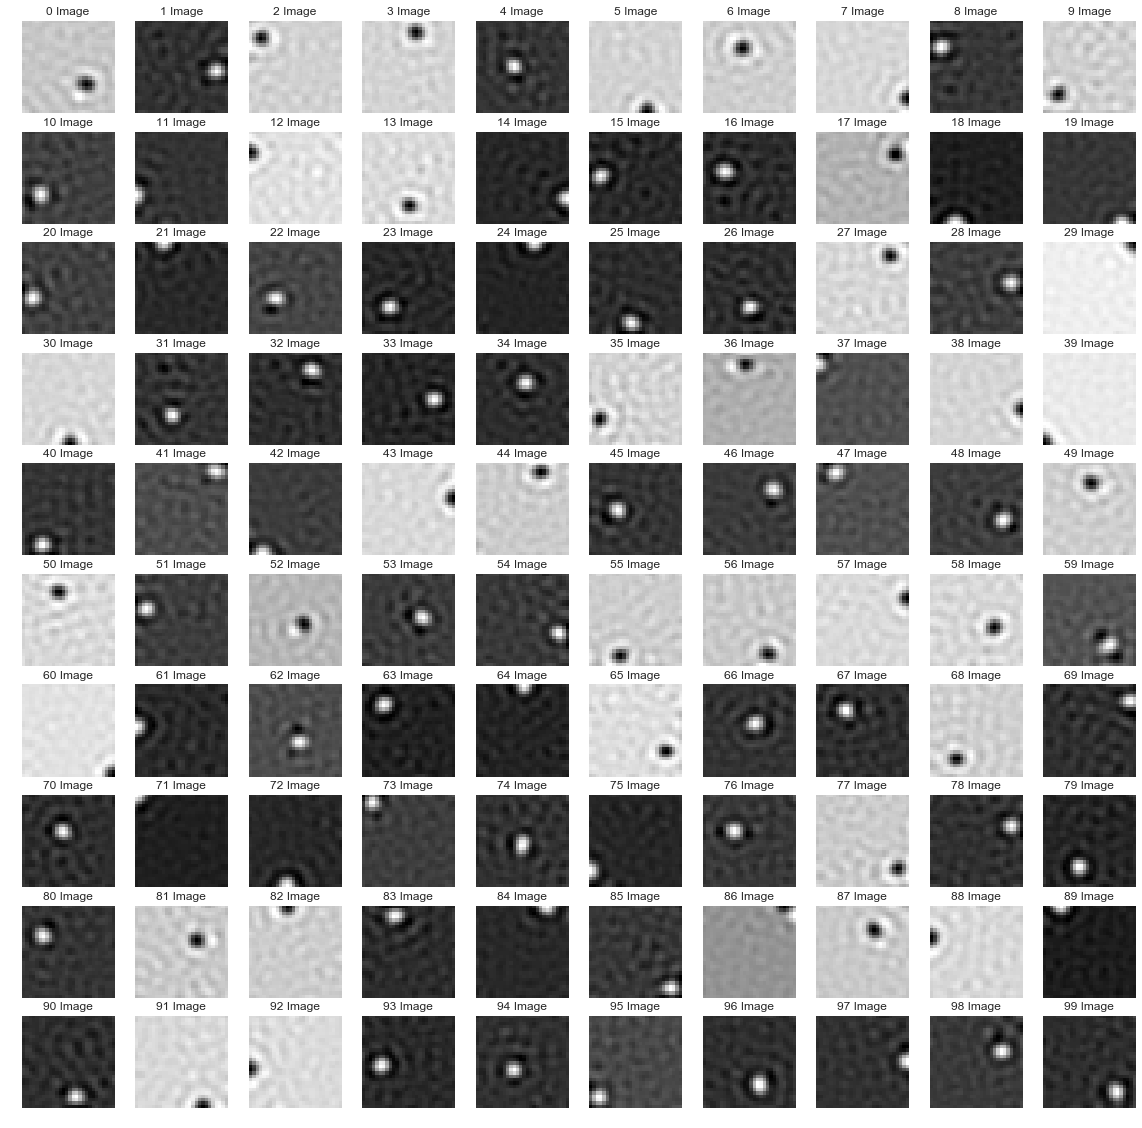

In [29]:
# Perform FastICA and view the results
from sklearn.decomposition import FastICA
fastica = FastICA(n_components=100)
fastica_data = fastica.fit_transform(train_data[:1000,:].reshape(1000,-1).T)
print(fastica_data.shape)
fig=plt.figure(figsize=(20, 20))
columns = 10; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(fastica_data[:,i-1].reshape((28,28)),cmap='gray')
    plt.axis('off')
    plt.title(str(i-1) + ' Image')
plt.show()

<IPython.core.display.Javascript object>


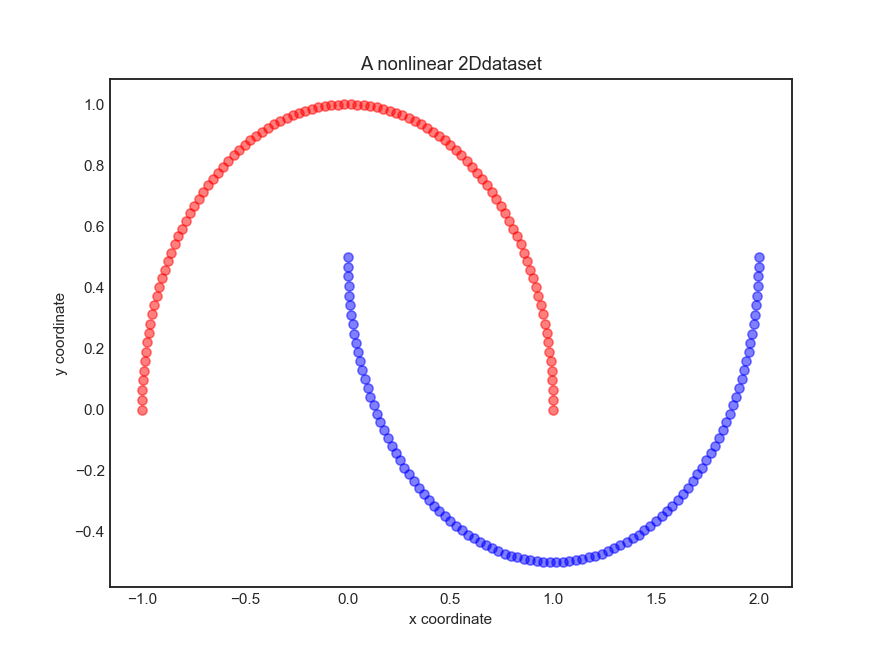

In [50]:
# try the KPCA on a smaller dimension dataset
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, random_state=123)

plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)

plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

<IPython.core.display.Javascript object>


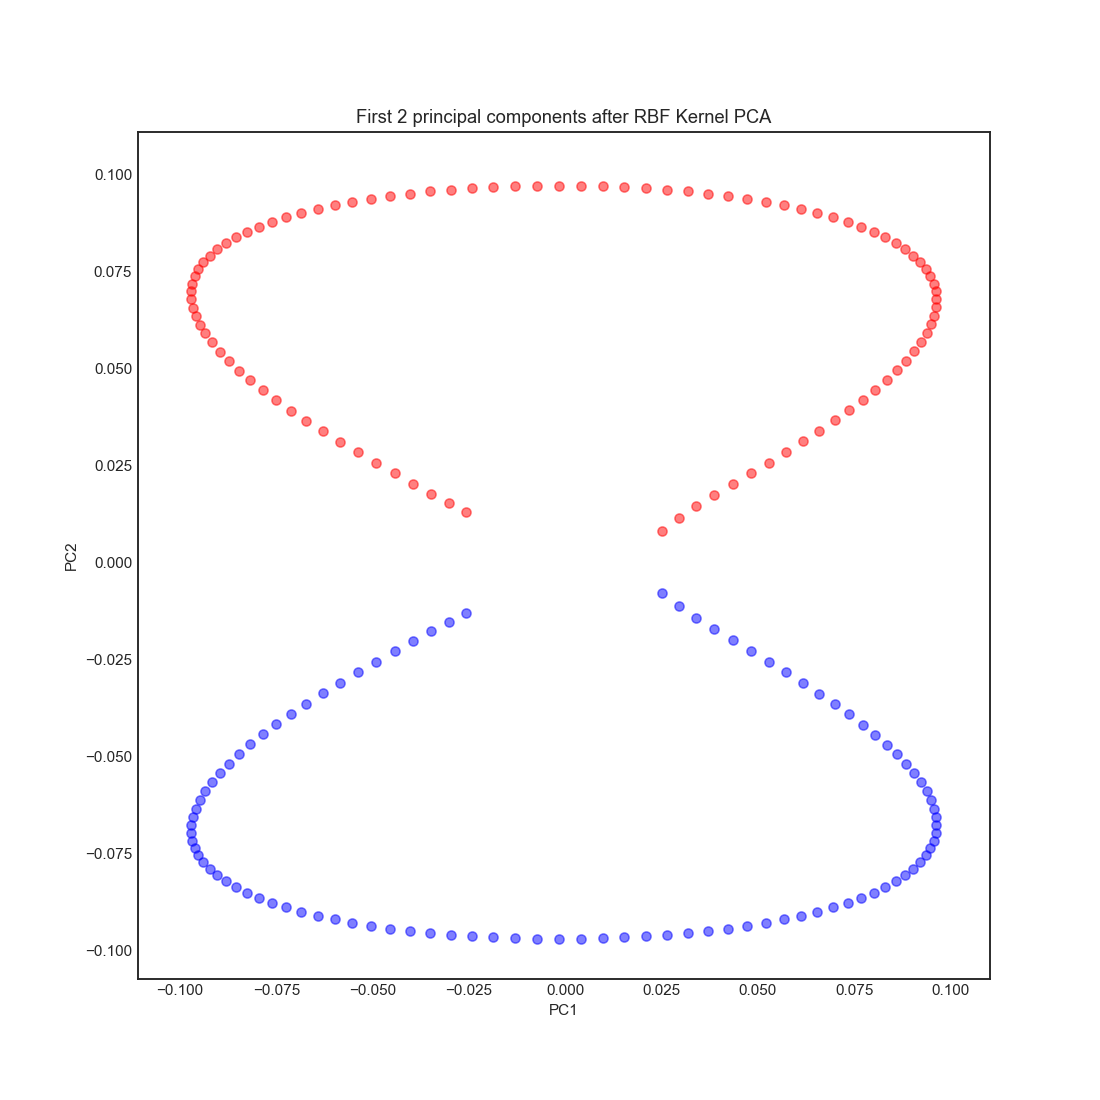

In [58]:
# perform KPCA and view 
kpca_l2 = KPCA_layer()
x = tf.placeholder(shape = [200,2],dtype = tf.float64)
reduced = kpca_l2.feedforward(x,2)
X = X.astype(np.float64)
sess_results = sess.run(reduced,feed_dict={x:X})
plt.figure(figsize=(10,10))
plt.scatter(sess_results[y==0, 0], sess_results[y==0, 1], color='red', alpha=0.5)
plt.scatter(sess_results[y==1, 0], sess_results[y==1, 1], color='blue', alpha=0.5)
plt.title('First 2 principal components after RBF Kernel PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

<IPython.core.display.Javascript object>


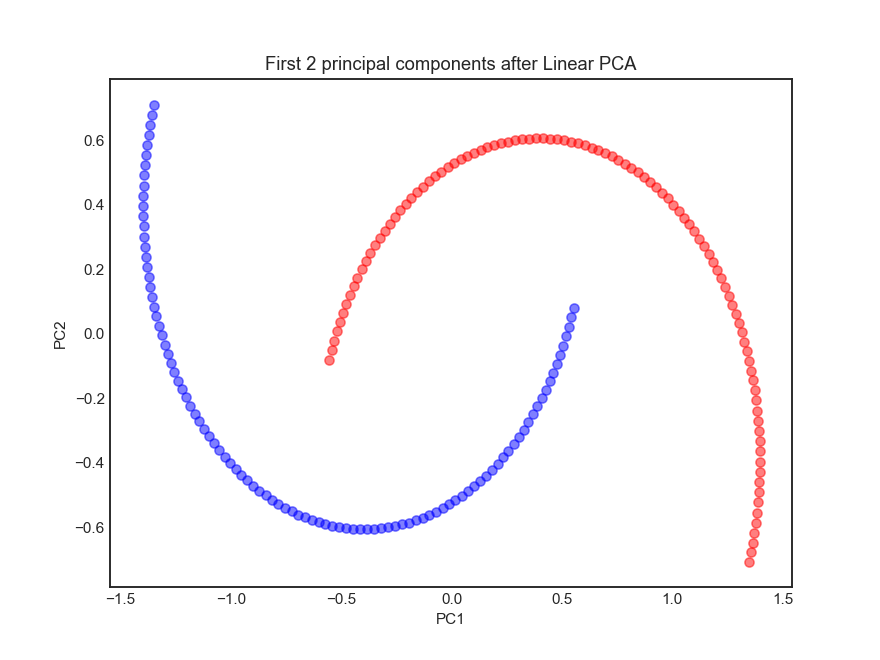

In [59]:
# PCA into 2 Dimesnion
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', alpha=0.5)

plt.title('First 2 principal components after Linear PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

<IPython.core.display.Javascript object>


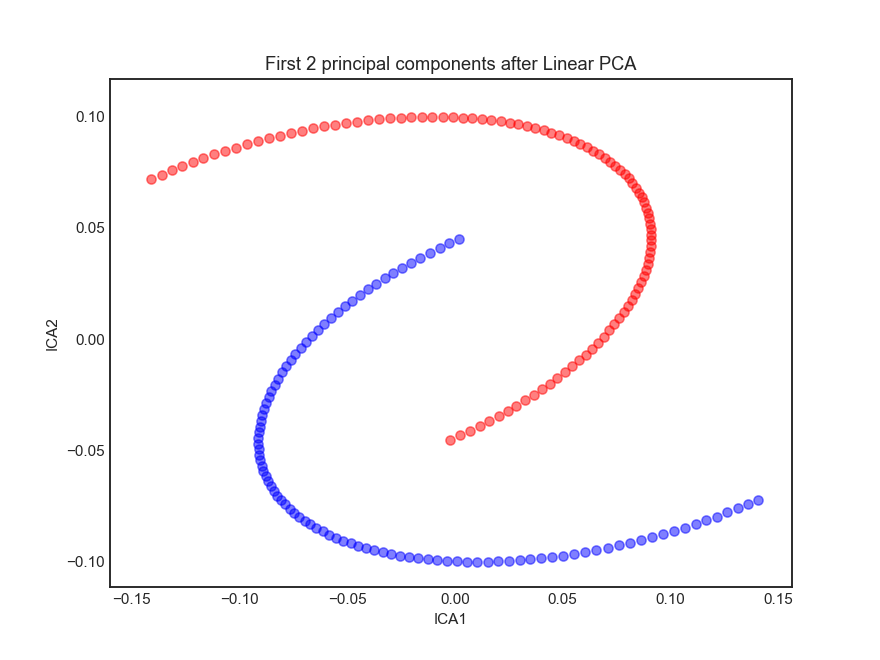

In [60]:
# smaller ICA
scikit_pca = FastICA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', alpha=0.5)

plt.title('First 2 principal components after Linear PCA')
plt.xlabel('ICA1')
plt.ylabel('ICA2')
plt.show()